# IPL  Prediction

In [423]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,classification_report,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

# EDA

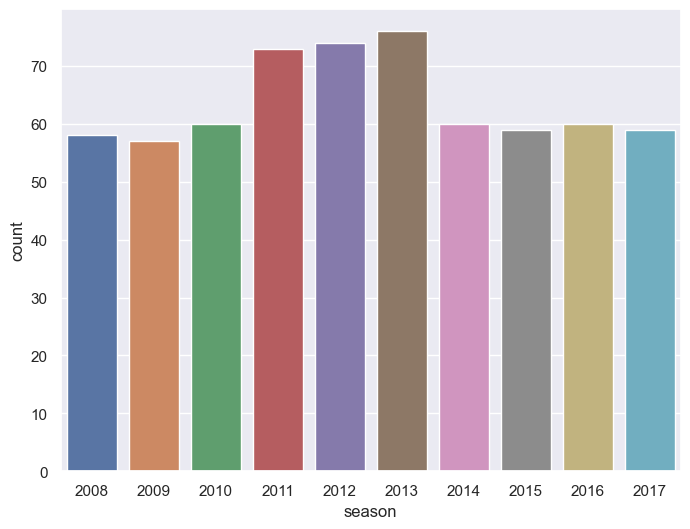

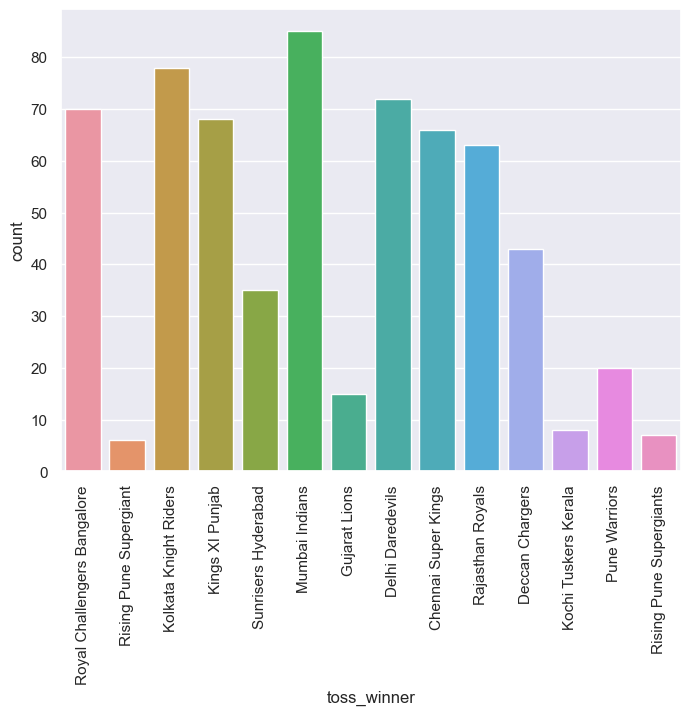

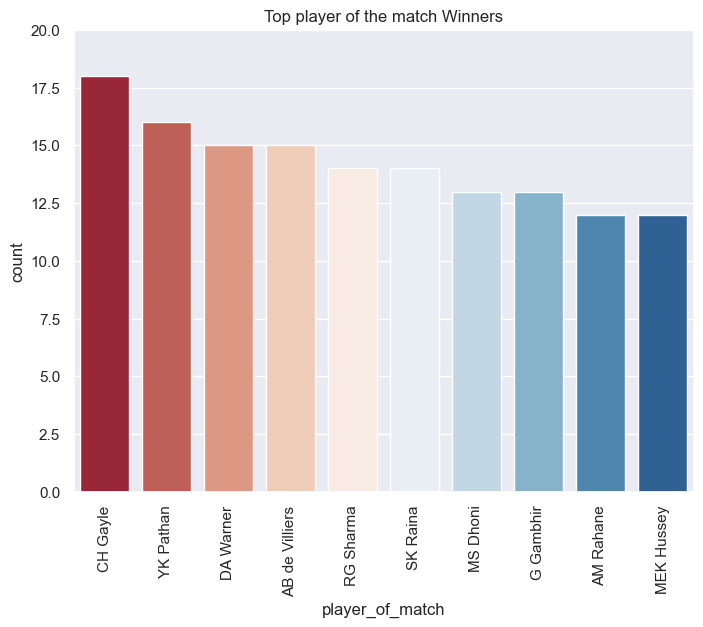

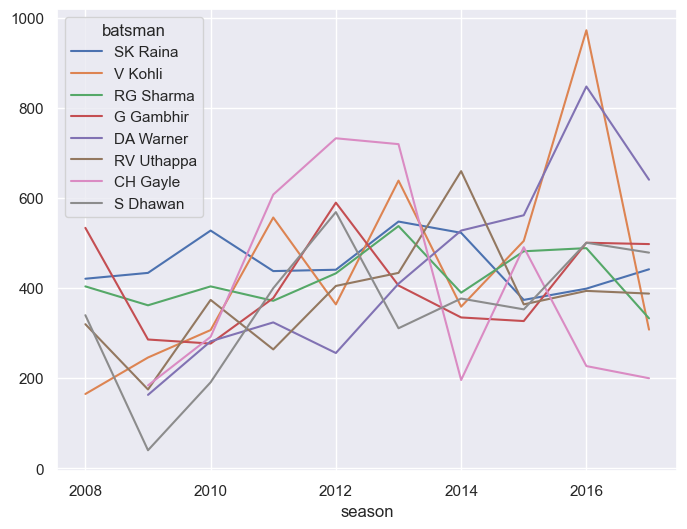

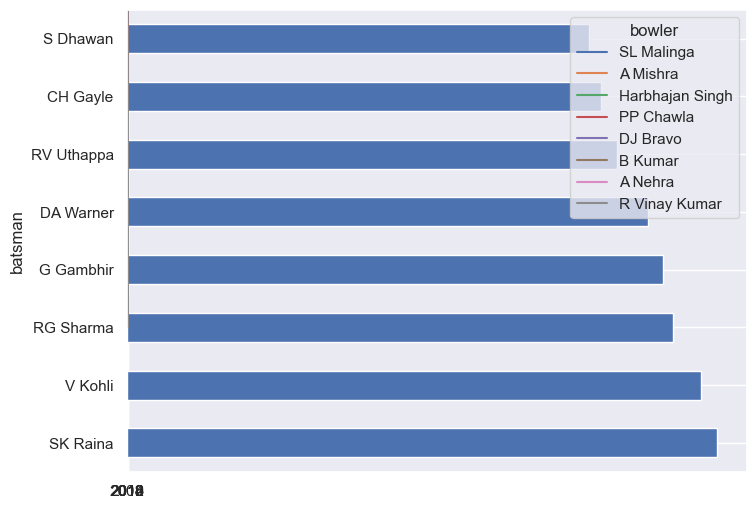

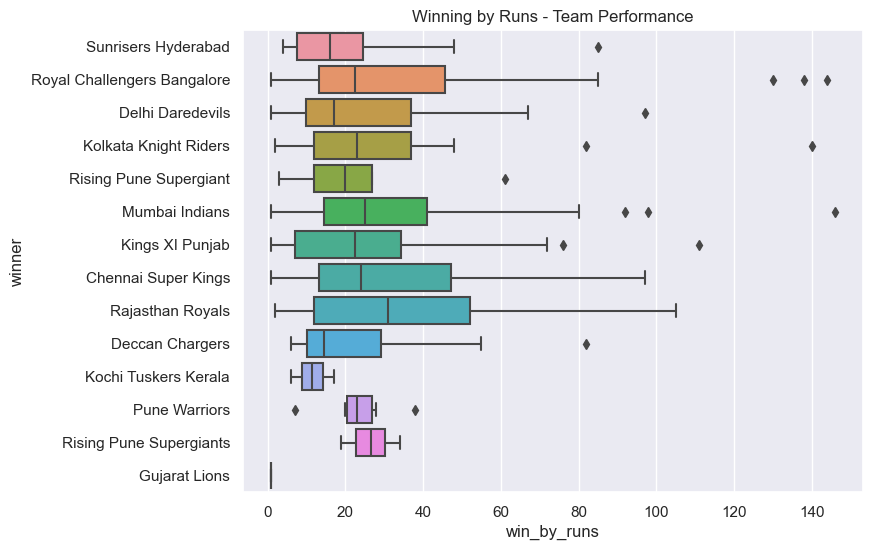

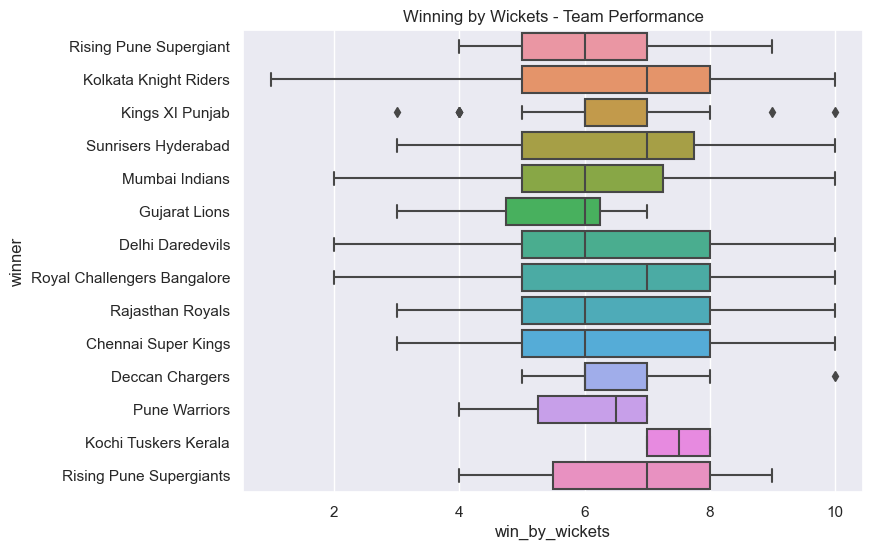

In [197]:
df=pd.read_csv('matches.csv')
df1=pd.read_csv('deliveries.csv')
df.head()
df1.head()

grp_batsman=df1.groupby(['match_id','inning','batting_team','batsman'])
batsman=grp_batsman['batsman_runs'].sum().reset_index()
faced_balls=df1[df1['wide_runs']==0]
faced_balls=faced_balls.groupby(['match_id','inning','batsman'])['batsman_runs'].count().reset_index()
faced_balls.columns=['match_id','inning','batsman','faced_balls']
batsman=batsman.merge(faced_balls,left_on=['match_id','inning','batsman'],right_on=['match_id','inning','batsman'],how='left')
fours=df1[df1['batsman_runs']==4]
sixes=df1[df1['batsman_runs']==6]
batsman_fours=fours.groupby(['match_id','inning','batsman'])['batsman_runs'].count().reset_index()
batsman_sixes=sixes.groupby(['match_id','inning','batsman'])['batsman_runs'].count().reset_index()
batsman_fours.columns=['match_id','inning','batsman','4s']
batsman_sixes.columns=['match_id','inning','batsman','6s']
batsman=batsman.merge(batsman_fours,left_on=['match_id','inning','batsman'],right_on=['match_id','inning','batsman'],how='left')
batsman=batsman.merge(batsman_sixes,left_on=['match_id','inning','batsman'],right_on=['match_id','inning','batsman'],how='left')
batsman['SR']=np.round(batsman['batsman_runs']/batsman['faced_balls']*100,2)
for col in ['batsman_runs','4s','6s','faced_balls','SR']:
    batsman[col]=batsman[col].fillna(0)
dismissals=df1[pd.notnull(df1['player_dismissed'])]
dismissals=dismissals[['match_id','inning','player_dismissed','dismissal_kind','fielder']]
dismissals.rename(columns={'player_dismissed':'batsman'},inplace=True)
batsman=batsman.merge(dismissals,left_on=['match_id','inning','batsman'],right_on=['match_id','inning','batsman'],how='left')
batsman=df[['id','season']].merge(batsman, left_on = 'id', right_on = 'match_id', how = 'left').drop('id', axis = 1)
batsman.head()

grp_bowler = df1.groupby(["match_id", "inning", "bowling_team", "bowler", "over"])  
bowlers = grp_bowler[["total_runs", "wide_runs", "bye_runs", "legbye_runs", "noball_runs"]].sum().reset_index()  
bowlers["runs"] = bowlers["total_runs"] - (bowlers["bye_runs"] + bowlers["legbye_runs"])  
bowlers["extras"] = bowlers["wide_runs"] + bowlers["noball_runs"]  
del( bowlers["bye_runs"])  
del( bowlers["legbye_runs"]) 
del( bowlers["total_runs"])  
dismissal_kinds_for_bowler = ["bowled", "caught", "lbw", "stumped", "caught and bowled", "hit wicket"]  
dismissals=df1[df1["dismissal_kind"].isin(dismissal_kinds_for_bowler)]  
dismissals=dismissals.groupby(["match_id", "inning", "bowling_team", "bowler", "over"])["dismissal_kind"].count().reset_index()  
dismissals.rename(columns={"dismissal_kind": "wickets"}, inplace=True)  
bowlers = bowlers.merge(dismissals, left_on=["match_id", "inning", "bowling_team", "bowler", "over"],right_on=["match_id", "inning", "bowling_team", "bowler", "over"], how="left")  
bowlers["wickets"] = bowlers["wickets"].fillna(0)  
over_bowlers = bowlers.groupby(['match_id', 'inning', 'bowling_team', 'bowler'])['over'].count().reset_index()  
bowlers = bowlers.groupby(['match_id', 'inning', 'bowling_team', 'bowler']).sum().reset_index().drop('over',axis= 1)  
bowlers = over_bowlers.merge(bowlers, on=["match_id", "inning", "bowling_team", "bowler"], how = 'left')  
bowlers['Econ'] = np.round(bowlers['runs'] / bowlers['over'] , 2)  
bowlers = df[['id','season']].merge(bowlers, left_on = 'id', right_on = 'match_id', how = 'left').drop('id', axis = 1)  
bowlers.head(10)  

df.describe()
sns.countplot(x='season',data=df)
plt.show()
sns.countplot(x='toss_winner',data=df)
plt.xticks(rotation=90)
plt.show()
top_players = df.player_of_match.value_counts()[:10]    
fig, ax = plt.subplots()  
ax.set_ylim([0,20])  
ax.set_ylabel("Number of Awards")  
ax.set_xlabel("Name of Players")  
ax.set_title("Top player of the match Winners")  
sns.barplot(x = top_players.index, y = top_players, orient='v', palette="RdBu");  
plt.xticks(rotation = 'vertical')  
plt.show()  
runsperseson_by_batsman = batsman.groupby(['season', 'batting_team', 'batsman'])['batsman_runs'].sum().reset_index()  
runsperseson_by_batsman = runsperseson_by_batsman.groupby(['season', 'batsman'])['batsman_runs'].sum().unstack().T  
runsperseson_by_batsman['Total'] = runsperseson_by_batsman.sum(axis=1) 
runsperseson_by_batsman = runsperseson_by_batsman.sort_values(by = 'Total', ascending = False).drop('Total', axis=1)  
ax.set_ylabel('Number of Runs')  
ax = runsperseson_by_batsman[:8].T.plot()  
wicketsperseason_by_bowler = bowlers.groupby(['season', 'bowling_team', 'bowler'])['wickets'].sum().reset_index()  
wicketsperseason_by_bowler = wicketsperseason_by_bowler.groupby(['season', 'bowler'])['wickets'].sum().unstack().T  
wicketsperseason_by_bowler ['Total'] = wicketsperseason_by_bowler .sum(axis=1) 
wicketsperseason_by_bowler  = wicketsperseason_by_bowler .sort_values(by = 'Total', ascending = False).drop('Total', axis=1)  
ax = wicketsperseason_by_bowler [:8].T.plot()  
runs_scored=batsman.groupby(['batsman'])['batsman_runs'].sum()  
runs_scored=runs_scored.sort_values(ascending=False)  
top10runs = runs_scored.head(8)  
top10runs.plot(kind='barh')  
plt.show()
fig, ax = plt.subplots()   
ax.set_xlabel("Runs")  
ax.set_title("Winning by Runs - Team Performance")  
sns.boxplot(y = 'winner', x = 'win_by_runs', data=df[df['win_by_runs']>0], orient = 'h'); 
plt.show()  
fig, ax = plt.subplots()  
ax.set_title("Winning by Wickets - Team Performance")   
sns.boxplot(y = 'winner', x = 'win_by_wickets', data=df[df['win_by_wickets']>0], orient = 'h'); 
plt.show()  

# Model Training

In [430]:
df1=pd.read_csv('matches1234.csv')
df1['city'].fillna('Dubai',inplace=True)
df1['umpire1'].fillna('Aleem Dar',inplace=True)
df1.drop(['win_by_runs','win_by_wickets','umpire1','city'],axis=1,inplace=True)
df1.isnull().sum()
df=pd.DataFrame(df1,columns=['season','team1', 'team2','toss_winner', 'toss_decision','venue','winner']) 
df['winner'].fillna('Draw', inplace=True)
df.loc[df['venue'] == 'Feroz Shah Kotla', 'venue'] = 'Arun Jaitley Stadium'
df.loc[df['venue'] == 'Sardar Patel Stadium, Motera', 'venue'] = 'Narendra Modi Stadium, Motera'
df.replace(['Mumbai Indians','Kolkata Knight Riders','Royal Challengers Bangalore','Deccan Chargers','Chennai Super Kings','Rajasthan Royals','Delhi Daredevils','Gujarat Lions','Kings XI Punjab','Sunrisers Hyderabad','Rising Pune Supergiants','Kochi Tuskers Kerala','Pune Warriors'],['MI','KKR','RCB','DC','CSK','RR','DD','GL','KXIP','SRH','RPS','KTK','PW'],inplace=True) 
encode = {'team1': {'MI':1,'KKR':2,'RCB':3,'DC':4,'CSK':5,'RR':6,'DD':7,'GL':8,'KXIP':9,'SRH':10,'RPS':11,'KTK':12,'PW':13},'team2': {'MI':1,'KKR':2,'RCB':3,'DC':4,'CSK':5,'RR':6,'DD':7,'GL':8,'KXIP':9,'SRH':10,'RPS':11,'KTK':12,'PW':13},'toss_winner': {'MI':1,'KKR':2,'RCB':3,'DC':4,'CSK':5,'RR':6,'DD':7,'GL':8,'KXIP':9,'SRH':10,'RPS':11,'KTK':12,'PW':13},'winner': {'MI':1,'KKR':2,'RCB':3,'DC':4,'CSK':5,'RR':6,'DD':7,'GL':8,'KXIP':9,'SRH':10,'RPS':11,'KTK':12,'PW':13,'Draw':14},'toss_decision':{'field':0,'bat':1},
'venue':{'Rajiv Gandhi International Stadium, Uppal':0,'Maharashtra Cricket Association Stadium':1,'Saurashtra Cricket Association Stadium':2, 'Holkar Cricket Stadium':3,'M Chinnaswamy Stadium':4, 'Wankhede Stadium':5, 'Eden Gardens':6,'Arun Jaitley Stadium':7,'Punjab Cricket Association IS Bindra Stadium, Mohali':8,'Green Park':9, 'Punjab Cricket Association Stadium, Mohali':8,'Sawai Mansingh Stadium':10, 'MA Chidambaram Stadium, Chepauk':11,'Dr DY Patil Sports Academy':5, 'Newlands':12, "St George's Park":13,'Kingsmead':14, 'SuperSport Park':15, 'Buffalo Park':16,'New Wanderers Stadium':17, 'De Beers Diamond Oval':18,'OUTsurance Oval':19, 'Brabourne Stadium':19,'Narendra Modi Stadium, Motera':20, 'Barabati Stadium':21,'Vidarbha Cricket Association Stadium, Jamtha':22,'Himachal Pradesh Cricket Association Stadium':23, 'Nehru Stadium':24,'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium':25,'Subrata Roy Sahara Stadium':1,'Shaheed Veer Narayan Singh International Stadium':26,'JSCA International Stadium Complex':27, 'Sheikh Zayed Stadium':28,'Sharjah Cricket Stadium':29, 'Dubai International Cricket Stadium':30}}  
df.replace(encode, inplace=True)  
df.dtypes  
df.head(15)
X=df.iloc[:,:-1].values
y=df.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 

In [431]:
# KNN
model=KNeighborsClassifier(n_neighbors=7)
model.fit(X_train,y_train)
print('Training Score:-',model.score(X_train,y_train))
print('Testing Score:-',model.score(X_test,y_test))

Training Score:- 0.5370786516853933
Testing Score:- 0.2617801047120419


In [432]:
# Decision Tree
model=DecisionTreeClassifier()
model.fit(X_train,y_train)
print('Training Score:-',model.score(X_train,y_train))
print('Testing Score:-',model.score(X_test,y_test))

Training Score:- 0.9977528089887641
Testing Score:- 0.46596858638743455


In [433]:
# Random Forest
model=RandomForestClassifier()
model.fit(X_train,y_train)
print('Training Score:-',model.score(X_train,y_train))
print('Testing Score:-',model.score(X_test,y_test))

Training Score:- 0.9977528089887641
Testing Score:- 0.4816753926701571


In [434]:
# Logistics Regression
model=LogisticRegression()
model.fit(X_train,y_train)
print('Training Score:-',model.score(X_train,y_train))
print('Testing Score:-',model.score(X_test,y_test))

Training Score:- 0.26292134831460673
Testing Score:- 0.20418848167539266


C:\Users\panka\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [435]:
# SVM
model=SVC()
model.fit(X_train,y_train)
print('Training Score:-',model.score(X_train,y_train))
print('Testing Score:-',model.score(X_test,y_test))

Training Score:- 0.15280898876404495
Testing Score:- 0.1256544502617801


In [436]:
# SGD
model=SGDClassifier()
model.fit(X_train,y_train)
print('Training Score:-',model.score(X_train,y_train))
print('Testing Score:-',model.score(X_test,y_test))

Training Score:- 0.1146067415730337
Testing Score:- 0.12041884816753927


In [437]:
# # Random Forest
# for i in range(1,14):
#     print(i)
#     model=RandomForestClassifier(max_depth=i,random_state=1)
#     model.fit(X_train,y_train)
#     print('Training Score:-',model.score(X_train,y_train))
#     print('Testing Score:-',model.score(X_test,y_test))
#     print('--------------------------------------------------------------------------------------')

In [438]:
# Random Forest
model=RandomForestClassifier(max_depth=9,random_state=1)
model.fit(X_train,y_train)
print('Training Score:-',model.score(X_train,y_train))
print('Testing Score:-',model.score(X_test,y_test))
pre=model.predict(X_test)

Training Score:- 0.9483146067415731
Testing Score:- 0.4973821989528796


In [439]:
df

,season,team1,team2,toss_winner,toss_decision,venue,winner
0,2017,10,3,3,0,0,10
1,2017,1,11,11,0,1,11
2,2017,8,2,2,0,2,2
3,2017,11,9,9,0,3,9
4,2017,3,7,3,1,4,3
...,...,...,...,...,...,...,...
631,2016,7,3,3,0,26,3
632,2016,8,3,3,0,4,3
633,2016,10,2,2,0,7,10
634,2016,8,10,10,0,7,10


In [441]:
input=[[2015,3,5,5,0,27]]
model.predict(input)

array([5], dtype=int64)

In [442]:
joblib.dump(model,'model.pkl')

['model.pkl']